In [30]:
import numpy
import math
import random
import time
import matplotlib.pyplot as plt

In [2]:
environment = numpy.zeros((5, 5))
trans_prob = 0.7
environment[3, 4] = 10

In [3]:
alpha = 0.5
gamma = 0.9

In [4]:
def get_legal_actions(pos):
    legal_actions = list()
    new_pos = list()
    all_actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    for i in all_actions:
        try:
            new_pos = numpy.add(pos, numpy.array(i))
            legal_actions.append(i)
            env = environment[new_pos[0]][new_pos[1]]
            if any(j < 0 for j in new_pos):
                legal_actions.pop()
        except IndexError:
            legal_actions.pop()
            
        
    return legal_actions

In [5]:
def take_action(pos, action):
    # Take action in the actual environment and return a reward and new position based on environment dynamics
    if numpy.random.rand(1) < 0.2:
        new_pos = numpy.add(pos, action)
    else:
        new_pos = numpy.add(pos, random.choice(get_legal_actions(pos)))
    reward = environment[new_pos[0]][new_pos[1]]
    return new_pos, reward

In [6]:
mb_internal_environment = numpy.zeros((5, 5))


In [7]:
def mb_internal_environment_value(pos):
    value = mb_internal_environment[pos[0], pos[1]]
    return value

In [8]:
def update_mb_internal_environment(pos, next_pos, reward):
    next_value_list = list()
    for i in get_legal_actions(next_pos):
        next_value_list.append(mb_internal_environment[next_pos[0]][next_pos[1]])
    next_value = max(next_value_list)
    mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos) + (alpha) * (reward + gamma*next_value)

In [9]:
def dls(pos, curr_depth, max_depth):
    value_list = list()
    if curr_depth == max_depth:
        return mb_internal_environment_value(pos)
    else:
        actions = get_legal_actions(pos)
        for i in actions:
            next_pos = numpy.add(numpy.array(pos), numpy.array(i))
            value = mb_internal_environment_value(pos) + gamma * dls(next_pos, curr_depth+1, max_depth)
            value_list.append(value)
        if value_list:
            average_value = numpy.mean(numpy.array(value_list))
    return average_value

In [10]:
def dls_action(pos, max_depth):
    # Do depth Limited Search till max_depth on the mb_internal_environment
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(dls(next_pos, 0, max_depth))
        next_pos_list.append(next_pos)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [11]:
def q_action(pos):
    # Look for q values in mf_internal_environment for given position
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(mb_internal_environment[next_pos[0], next_pos[1]])
        next_pos_list.append(next_pos)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [12]:
def dual(num_iters, steps_per_iter):
    sum_reward = 0
    max_depth = 4
    for i in range(num_iters):
        pos = [0, 0]
        for j in range(steps_per_iter):
            if j%(i+1) == 0:
                action = dls_action(pos, max_depth)
                next_pos, reward = take_action(pos, action)
                update_mb_internal_environment(pos, next_pos, reward)
                pos = next_pos
            else:
                action = q_action(pos)
                next_pos, reward = take_action(pos, action)
                update_mb_internal_environment(pos, next_pos, reward)
                pos = next_pos
            sum_reward += reward
    return sum_reward

In [13]:
def mb(num_iters, steps_per_iter):
    sum_reward = 0
    max_depth = 4
    for i in range(num_iters):
        pos = [0, 0]
        for j in range(steps_per_iter):
            action = dls_action(pos, max_depth)
            next_pos, reward = take_action(pos, action)
            update_mb_internal_environment(pos, next_pos, reward)
            pos = next_pos
            sum_reward += reward
    return sum_reward

In [14]:
def mf(num_iters, steps_per_iter):
    sum_reward = 0
    max_depth = 4
    for i in range(num_iters):
        pos = [0, 0]
        for j in range(steps_per_iter):
            action = q_action(pos)
            next_pos, reward = take_action(pos, action)
            update_mb_internal_environment(pos, next_pos, reward)
            pos = next_pos
            sum_reward += reward
    return sum_reward

In [15]:
mb_internal_environment = numpy.zeros((5, 5))


Run the Dual Process on grid world. Get a list of individual time taken for each and rewards obtained.

In [26]:
times_dual = list()
reward_dual = list()
for i in range(20):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    reward_dual.append(dual(40, 24))
    times_dual.append(time.time() - start_time)
print (times_dual)
print (reward_dual)

[0.9158928394317627, 0.7143638134002686, 0.7276911735534668, 0.7102200984954834, 0.6785447597503662, 0.7192459106445312, 0.7012913227081299, 0.719804048538208, 0.7651691436767578, 0.7381784915924072, 0.7119762897491455, 0.7234270572662354, 0.7170059680938721, 0.7201838493347168, 0.7348880767822266, 0.7142274379730225, 0.7016327381134033, 0.7236471176147461, 0.7141249179840088, 0.700660228729248]
[530.0, 490.0, 360.0, 550.0, 590.0, 540.0, 420.0, 370.0, 360.0, 540.0, 440.0, 490.0, 460.0, 340.0, 320.0, 580.0, 630.0, 410.0, 410.0, 420.0]


In [27]:
times_mb = list()
reward_mb = list()
for i in range(20):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    reward_mb.append(mb(40, 24))
    times_mb.append(time.time() - start_time)
print (times_mb)
print (reward_mb)

[6.97906494140625, 6.705512762069702, 6.388406276702881, 6.849632501602173, 6.928613662719727, 6.799907684326172, 6.8535308837890625, 6.903970241546631, 6.544677019119263, 6.3058998584747314, 6.669878959655762, 6.741959810256958, 6.604400396347046, 6.825824737548828, 6.8393237590789795, 6.867632865905762, 6.78385329246521, 6.712416648864746, 6.743344068527222, 6.731619119644165]
[550.0, 470.0, 620.0, 580.0, 420.0, 600.0, 610.0, 560.0, 430.0, 510.0, 400.0, 540.0, 630.0, 600.0, 500.0, 520.0, 560.0, 440.0, 490.0, 570.0]


In [28]:
times_mf = list()
reward_mf = list()
for i in range(20):
    mb_internal_environment = numpy.zeros((5, 5))
    start_time = time.time()
    reward_mf.append(mf(40, 24))
    times_mf.append(time.time() - start_time)
print (times_mf)
print (reward_mf)

[0.07032608985900879, 0.06940031051635742, 0.06765198707580566, 0.06753969192504883, 0.06870007514953613, 0.06742405891418457, 0.06732439994812012, 0.06748700141906738, 0.06741976737976074, 0.06702518463134766, 0.0690915584564209, 0.06876111030578613, 0.07081770896911621, 0.06711053848266602, 0.06751680374145508, 0.06732416152954102, 0.0674893856048584, 0.0676414966583252, 0.06685113906860352, 0.06682801246643066]
[470.0, 520.0, 460.0, 320.0, 510.0, 410.0, 380.0, 390.0, 600.0, 530.0, 530.0, 540.0, 430.0, 470.0, 540.0, 440.0, 340.0, 250.0, 650.0, 380.0]


In [65]:
reward_mean_dual = numpy.mean(numpy.array(reward_dual))
reward_mean_mb = numpy.mean(numpy.array(reward_mb))
reward_mean_mf = numpy.mean(numpy.array(reward_mf))
times_mean_dual = numpy.mean(numpy.array(times_dual))
times_mean_mb = numpy.mean(numpy.array(times_mb))
times_mean_mf = numpy.mean(numpy.array(times_mf))


In [66]:
reward_errors = ([max(reward_dual) - numpy.mean(numpy.array(reward_dual)), max(reward_mb) - numpy.mean(numpy.array(reward_mb)), max(reward_mf) - numpy.mean(numpy.array(reward_mf))]), 

In [67]:
times_errors = ([max(times_dual) - numpy.mean(numpy.array(times_dual)), max(times_mb) - numpy.mean(numpy.array(times_mb)), max(times_mf) - numpy.mean(numpy.array(times_mf))]), 

In [73]:
rewards = numpy.array([reward_mean_mb, reward_mean_dual, reward_mean_mf])
yerror = numpy.array(reward_errors)
print (rewards)

[ 530.   462.5  458. ]


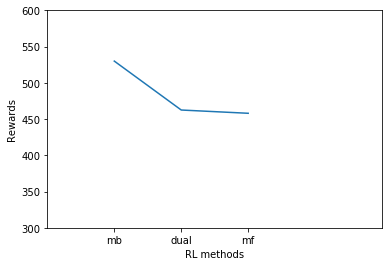

In [74]:
reward_plot, = plt.plot(numpy.arange(0, 3), rewards)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
plt.ylim(ymin = 300, ymax = 600)
plt.xlabel('RL methods')
plt.ylabel("Rewards")

plt.show()

[ 6.73897347  0.72760876  0.06798652]


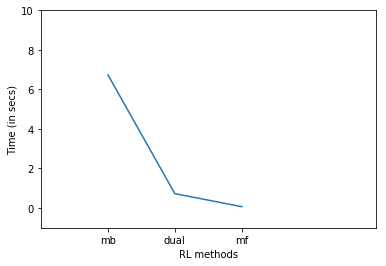

In [79]:
times = numpy.array([times_mean_mb, times_mean_dual, times_mean_mf])
print (times)
reward_plot, = plt.plot(numpy.arange(0, 3), times)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
plt.ylim(ymin = -1, ymax = 10)
plt.xlabel('RL methods')
plt.ylabel("Time (in secs)")

plt.show()